In [2]:
import numpy as np
from calibration import placeinducingpoints, CalibrationSystem, SparseModel, Kernel
import gpflow
import matplotlib.pyplot as plt
%matplotlib inline

## Scaling Only Demo

Here we have four sensors, their calibration remains constant (although the model doesn't know that).

In [3]:
X = np.array([[3.0,0,1],
             [4.0,0,1],
             [5.0,0,1],
             [6.0,1,2],
             [7.0,1,2],
             [8.0,1,2],
             [9.0,1,2],
             [1.0,2,3],
             [2.0,2,3],
             [3.0,2,3],
             [10.5,2,3], 
             [14.0,3,0]])

Y = np.array([[10,20],[15,30],[16,32],[30,20],[33,22],[21,14],[30,20],[20,20],[20,21],[22,23],[15,14],[20,15]])
refsensor = np.array([1,0,0,0])
Z = np.linspace(0,15,5)[:,None]

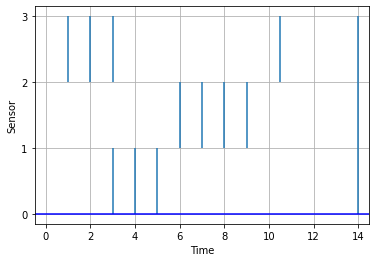

In [4]:
for x in X:
    plt.vlines(x[0],x[1],x[2])
plt.yticks(np.arange(0,3+1),np.arange(0,3+1))
plt.ylabel('Sensor')
plt.xlabel('Time')
plt.hlines(0,-1,15,'b')
plt.xlim([-0.5,14.5])
plt.grid()

In [5]:
import tensorflow as tf
import tensorflow_probability as tfp
tfd = tfp.distributions
psd_kernels = tfp.math.psd_kernels
import pandas as pd
import numpy as np
from tensorflow_probability import distributions as tfd

In [6]:
def transform_fn(samps,Y):
    return Y*samps[:,:,0:1]

k = gpflow.kernels.RBF(1,15)+gpflow.kernels.Bias(1)
cs = CalibrationSystem(X, Y, Z, refsensor, 2, transform_fn, k,likelihoodstd=0.5)
cs.run(its=500)

TypeError: __init__() missing 1 required positional argument: 'kernelindices'

In [ ]:
#build test matrix
C = 2
for si,refs in enumerate(refsensor):
    if refs: continue
    x = np.linspace(0,15,151)
    testX = np.zeros([0,3])
    for ci in range(C):
        tempX = np.c_[x,np.ones_like(x)*si,np.full_like(x,ci)]
        testX = np.r_[testX,tempX]#.astype(int)
    testsm = SparseModel(testX,cs.Z,C,Kernel(k))
    qf_mu,qf_cov = testsm.get_qf(cs.mu,cs.scale)
    samps = testsm.get_samples_one_sensor(cs.mu,cs.scale)

    plt.figure(figsize=[6,4])
    plt.plot(x,samps[:,:,0].numpy().T,'k.',alpha=0.01);
    #plt.plot(-getsensorshift(x,np.ones_like(x).astype(int)))
    plt.grid()
    plt.vlines(Z[:,0],-.3,-.2)
    plt.ylim([-.2,1.2])
    if si==1: plt.hlines(0.5,0,15)
    if si==2: plt.hlines(0.75,0,15)
    if si==3: plt.hlines(0.75,0,15)
    break

In [ ]:
plt.plot(x,np.exp(samps[:,:,1].numpy().T-5),'b.',alpha=0.1);

In [ ]:
testX

In [ ]:
plt.plot(qf_mu[:151,0])

In [ ]:
plt.plot(np.exp(qf_mu[151:,0]))

## Linear transform demo

Just two sensors, the low-cost sensor has a drift in which its offset increases over time.

There is obviously some ambiguity from the model's point of view as to whether the difference between the sensors is due scaling or offset.

In [ ]:
X = np.c_[np.linspace(0,20,21),np.zeros(21),np.ones(21)]
y = np.cos(X[:,0])*25+100
Y = np.c_[y,y+X[:,0]]
refsensor = np.array([1,0])
Z = np.linspace(0,20,5)[:,None]

In [ ]:
#def transform_fn(samps,Y):
#    return 100*(samps[:,:,0:1]) + Y*samps[:,:,1:2] + (samps[:,:,2:3]*Y**2)/1000

def transform_fn(samps,Y):
    return 100*samps[:,:,0:1] + Y*samps[:,:,1:2]

k = gpflow.kernels.RBF(1,15)+gpflow.kernels.Bias(1)
cs = CalibrationSystem(X, Y, Z, refsensor, 2, transform_fn, k,likelihoodstd=0.05)
cs.run(its=1000)

In [ ]:
#build test matrix
C = 2
for si,refs in enumerate(refsensor):
    if refs: continue
    x = np.linspace(0,15,151)
    testX = np.zeros([0,3])
    for ci in range(C):
        tempX = np.c_[x,np.ones_like(x)*si,np.full_like(x,ci)]
        testX = np.r_[testX,tempX]#.astype(int)
    testsm = SparseModel(testX,cs.Z,C,Kernel(k))
    qf_mu,qf_cov = testsm.get_qf(cs.mu,cs.scale)
    samps = testsm.get_samples_one_sensor(cs.mu,cs.scale)

    plt.figure(figsize=[6,4])
    plt.plot(x,samps[:,:,1].numpy().T,'k.',alpha=0.01);
    plt.plot(x,100*samps[:,:,0].numpy().T,'b.',alpha=0.01);
    #plt.plot(-getsensorshift(x,np.ones_like(x).astype(int)))
    plt.grid()
    plt.vlines(Z[:,0],-.3,-.2)
    plt.ylim([-20,2])
    plt.xlim([0,15])
    plt.hlines(1,0,15,'k',label='scale')
    plt.plot([0,15],[0,-15],'b-',label='offset')
    plt.legend(loc='lower left')